# Exercise 3. Multi-class Classification and Neural Networks

In this exercise, you will implement **one-vs-all logistic regression and neural networks**
to recognize hand-written digits. Before starting the programming exercise, we strongly 
recommend watching the video lectures and completing the review questions for the associated
topics. For details see **ex3.pdf**

We will implement a Forward propagate 3 layers neural network class **```ForwardPropagation```** and 
Logistic regression regularized multiclass class **```LogisticRegRegularizedMulticlass```** using 
mathematical concepts and algorithms without using any ML library then in the following section we will 
use them in exercise 3 of the course.

The classes are split into multiple cells using **```jdc```** package so that notes can be written for learning and understanding. 
Complete implementation of the classes are under **```src/supervised/neural_networks/forward_propagation.py```** and
under **```src/supervised/logistic_regression_regularized_multiclass.py```** module of this repository.

Following cell declares the class **```LogisticRegRegularizedMulticlass```** with its basic attributes and common utility members.

In [21]:
import jdc
import math
import numpy as np
import scipy.optimize as opt
import copy

import src.utils.displaydata as disp
import src.utils.label_mapping as mappings

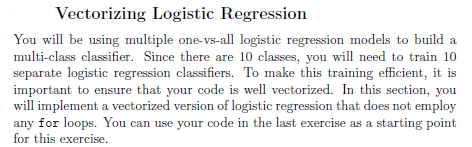

In [22]:
class LogisticRegRegularizedMulticlass(object):
    '''
    Logistic regression regularized multi-class classifier,
    implements both vectorized and non vectorized versions.
    '''
    def __init__(self):
        '''
        Initialize attributes.
        '''
        # Number of training samples.
        self.m = 0
        self.classes_min_theta = list()
        # Array to keep J(theta) for each iteration.
        self.classes_costs = list()
    
    
    def predict_one_vs_all(self, V):
        '''
        Predict the label for a trained one-vs-all classifier. 
        The labels are in the range 1..K, where K = size(all_theta, 1).
    
        Arguments:
          V (m x n float matrix): Test examples matrix.
    
        Return:
          (1d int array): Predicted labels for each test example in the
          matrix V.
        '''
        # We add a column i.e x0=1 hence shape 
        # becomes m x n+1.
        X = np.ones(shape=(V.shape[0], V.shape[1] + 1))
        # First column will be 1.
        X[:,1:] = V
        labels = np.zeros(X.shape[0], dtype=np.int32)
    
        for i, x in enumerate(X):
          predictions = [np.sum(x * t) for t in self.classes_min_theta]
          labels[i] = np.argmax(predictions)
        return labels
    
    
    def one_vs_all_vectorized(self, M, y, num_labels, lmda=0.1):
        '''
        Train multiple logistic regression classifiers using
        vectorized algorithm and saves all the classifiers internally.
    
        Arguments:
          M (m x n float matrix): Training examples.
          y (m 1d int array): Outputs of training examples.
          num_labels (1d int array): Labels of images such 0...9
          lmda (float): Lambda value for regularization.
        '''
        print('Executing vectorized version of algorithm...')
    
        # We add a column i.e x0=1 hence shape 
        # becomes m x n+1.
        X = np.ones(shape=(M.shape[0], M.shape[1] + 1))
        # First column will be 1.
        X[:,1:] = M
        self.m = X.shape[0]
    
        # Labels are nothing but digits 0,1..9.
        for i in num_labels:
          label = copy.deepcopy(y)
          # Set outputs negatives or positives.
          label[label == i] = -1  # Set temp flag.
          label[label != -1] = 0  # Set negative.
          label[label == -1] = 1  # Set negative.
    
          # Train and get cost min theta and cost for
          # each class.
          cost, min_theta = self._train_vectorized(X, label, lmda)
          self.classes_costs.append(cost)
          self.classes_min_theta.append(min_theta)
          print('{} min cost estimation for label {}'.format(cost, i))
    
    
    def one_vs_all_non_vectorized(self, M, y, num_labels, lmda=0.1):
        '''
        Train multiple logistic regression classifiers using
        non vectorized algorithm and saves all the classifiers internally.
    
        Arguments:
          M (m x n float matrix): Training examples.
          y (m 1d int array): Outputs of training examples.
          num_labels (1d int array): Labels of images such 0...9
          lmda (float): Lambda value for regularization.
        '''
        print('Executing non vectorized version of algorithm...')
    
        # We add a column i.e x0=1 hence shape 
        # becomes m x n+1.
        X = np.ones(shape=(M.shape[0], M.shape[1] + 1))
        # First column will be 1.
        X[:,1:] = M
        self.m = X.shape[0]
        X = np.transpose(X)
    
        # Labels are nothing but digits 0,1..9.
        for i in num_labels:
          label = copy.deepcopy(y)
          # Set outputs negatives or positives.
          label[label == i] = -1  # Set temp flag.
          label[label != -1] = 0  # Set negative.
          label[label == -1] = 1  # Set negative.
    
          # Train and get cost min theta and cost for
          # each class.
          cost, min_theta = self._train_non_vectorized(X, label, lmda)
          self.classes_costs.append(cost)
          self.classes_min_theta.append(min_theta)
          print('{} min cost estimation for label {}'.format(cost, i))

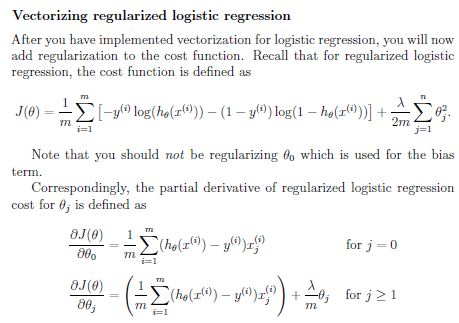

In [23]:
%%add_to LogisticRegRegularizedMulticlass

def _train_vectorized(self, X, y, lmda):
    '''
    Call scipy's fming_cg function for optimization for
    vectorized algorithm.

    Arguments:
      X (m x n float matrix): Training examples.
      y (m 1d int array): Outputs of training examples.
      lmda (float): Lambda value for regularization.

    Return:
      (float): Cost.
      (1d float array): Minimum thetas.
    '''
    theta = np.zeros(X.shape[1])
    args = (X, y, lmda)
    res = opt.fmin_cg(self._cost_vectorized, 
                      x0=theta, 
                      fprime=self._gradient_vectorized,
                      args=args, 
                      maxiter=200, 
                      disp=False, 
                      full_output=True)
    return res[1], res[0] # cost, thetas

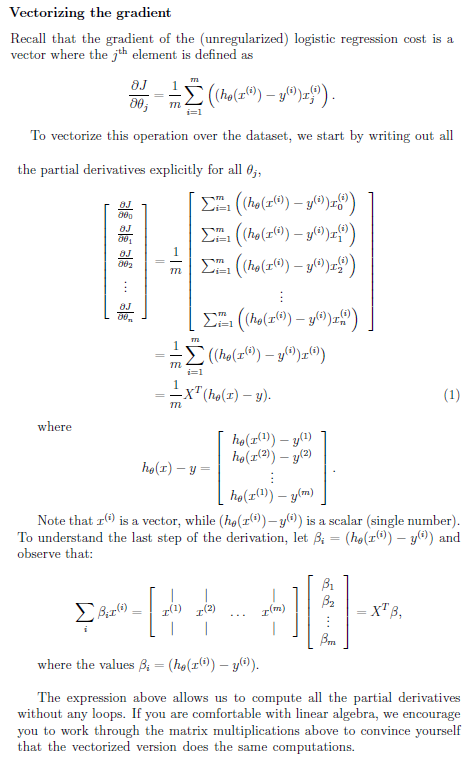

In [24]:
%%add_to LogisticRegRegularizedMulticlass

def _gradient_vectorized(self, theta, X, y, lmda):
    '''
    Compute gradient for vectorized algorithm.

    Arguments:
      theta (1d float array): Theta or parameter.
      X (m x n float matrix): Training examples.
      y (m 1d int array): Outputs of training examples.
      lmda (float): Lambda value for regularization.

    Return:
      (1d float array): Gradients.
    '''
    theta = theta.reshape((X.shape[1], 1))

    # Compute gradients.
    Z = X.dot(theta)
    h = 1.0 / (1.0 + np.exp(-Z))
    grads = X.transpose().dot(h - y) / self.m

    # Add regularization.
    t = theta[:,:]
    t[0] = 0
    grads += (lmda / self.m) * t
    return grads.flatten()


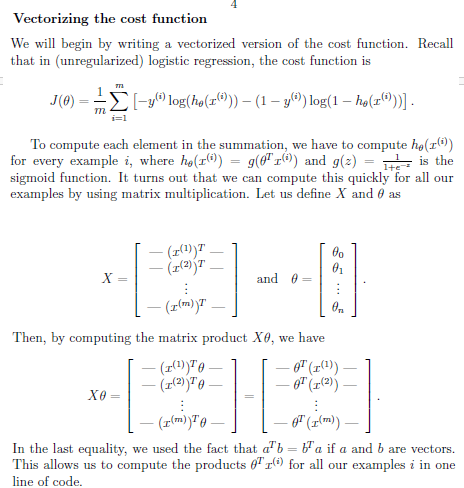

In [25]:
%%add_to LogisticRegRegularizedMulticlass

def _cost_vectorized(self, theta, X, y, lmda):
    '''
    Compute cost for vectorized algorithm.

    Arguments:
      theta (1d float array): Theta or parameter.
      X (m x n float matrix): Training examples.
      y (m 1d int array): Outputs of training examples.
      lmda (float): Lambda value for regularization.

    Return:
      (float): The cost J for the given theta values vector.
    '''
    theta = theta.reshape((X.shape[1], 1))

    # Compute cost.
    Z = X.dot(theta)
    h = 1.0 / (1.0 + np.exp(-Z))
    likelihood = np.sum((y * np.log(h)) + ((1.0 - y) * np.log(1.0 - h)))

    # Add regularization.
    Jtheta_reg = (lmda / (2 * self.m)) * np.sum(theta ** 2)
    cost = -(likelihood / self.m) + Jtheta_reg
    return cost


In [26]:
%%add_to LogisticRegRegularizedMulticlass

def _train_non_vectorized(self, X, y, lmda):
    '''
    Call scipy's fming_cg function for optimization for
    non vectorized algorithm.

    Arguments:
      X (m x n float matrix): Training examples.
      y (m 1d int array): Outputs of training examples.
      lmda (float): Lambda value for regularization.

    Return:
      (float): Cost.
      (1d float array): Minimum thetas.
    '''
    theta = np.zeros(X.shape[0])
    args = (X, y, lmda)
    res = opt.fmin_cg(self._cost__non_vectorized, 
                      x0=theta, 
                      fprime=self._gradient__non_vectorized,
                      args=args, 
                      maxiter=200, 
                      disp=False, 
                      full_output=True)
    return res[1], res[0] # cost, thetas


In [27]:
%%add_to LogisticRegRegularizedMulticlass

def _gradient__non_vectorized(self, theta, X, y, lmda):
    '''
    Compute gradient descent to learn theta values for
    non vectorized algorithm.

    Arguments:
      theta (n x 1 float vector): Theta values vector.
      X (n x m float matrix): Feature values vectors, e.g.
        1   1  1  . .
        a1  b1 c1 . .
        a2  b2 c2 . .
        .   .  .  . .
        .   .  .  . .
        Notice dimension of feature vectors are by columns 
        NOT by rows.
      y (1d float array): Output of the features vectors in 
        the training data such as 0s or 1s.
      lmda (float): Lambda value for regularization.

    Return:
      (1d float array): A gradient values vector, size of
        vector will match 'theta' vector.
    '''
    theta = theta.reshape((X.shape[0], 1))
    grad = np.zeros_like(theta)

    # Iterate over columns.
    for i, yi in enumerate(y):
      xi = X[:, [i]]
      h = self._sigmoid__non_vectorized(xi, theta)
      grad += (h - yi) * xi

    # Grads regularization, same shape as theta.
    grads_reg = np.zeros_like(grad)
    grads_reg = (lmda / self.m) * theta
    # Set extra term.
    grads_reg[0] = 0
    grad = (grad / self.m) + grads_reg
    return grad.flatten()


In [28]:
%%add_to LogisticRegRegularizedMulticlass

def _cost__non_vectorized(self, theta, X, y, lmda):
    '''
    Compute cost of the hypothesis for the given
    theta values for non vectorized algorithm.

    Arguments:
      theta (n x 1 float vector): Theta values vector.
      X (n x m float matrix): Feature values vectors, e.g.
        1   1  1  . .
        a1  b1 c1 . .
        a2  b2 c2 . .
        .   .  .  . .
        .   .  .  . .
        Notice dimension of feature vectors are by columns 
        NOT by rows.
      y (1d float array): Output of the features vectors in 
        the training data such as 0s or 1s.
      lmda (float): Lambda value for regularization.


    Return:
      (float): The cost J for the given theta values vector.
    '''
    theta = theta.reshape((X.shape[0], 1))
    likelihood = 0.0

    # Iterate over columns.
    for i in range(X.shape[1]):
      h = self._sigmoid__non_vectorized(X[:, [i]], theta)
      likelihood += ((y[i] * math.log(h)) + ((1.0 - y[i]) * math.log(1.0 - h)))

    # J(theta) is cost of the hypothesis.
    Jtheta_reg = ((lmda / (2 * self.m)) * (np.sum(theta ** 2)))
    cost = -(likelihood / (self.m)) + Jtheta_reg
    return cost[0]


In [29]:
%%add_to LogisticRegRegularizedMulticlass

def _sigmoid__non_vectorized(self, xi, theta):
    '''
    Compute sigmoid function.

    Arguments:
      xi (n x 1 float vector): Feature values vector.
      theta (n x 1 float vector): Theta values vector.

    Return:
      (float): A sigmoid value.
    '''
    z = np.transpose(theta).dot(xi)
    return 1.0 / (1.0 + math.exp(-z))


##### Following cell declares the class **```ForwardPropagation```** with its basic attributes and common utility members. Complete implementation of the classes are under **```src/supervised/neural_networks/forward_propagation.py```**

##### Forward propagate 3 layers neural network

In [30]:
class ForwardPropagation(object):
    '''Forward propagate 3 layers neural network.'''

    def predict(self, M, theta1, theta2):
        '''
        Predict the label of an input given a 3 layers trained
        neural network by forwarding.
        Outputs the predicted label of M given the trained weights
        of a neural network (theta1, theta2). 
        
        Predicted labels are digits 0,1,2...9 but remember it is
        according to Python 0-based indexing, you need mapping.
    
        Remember in assignment labels were according to
        Matlab indexing which is 1-based indexing.
    
        Hence 1,2..9 are as 1,2..9 but 0 is as 10. For
        details see the description of Assignment No 3.
    
        Arguments:
          M (m x n float matrix):  Training examples.
          theta1 (m x n float matrix): Pre-calculated layer 1 parameters/weights.
          theta2 (m x n float matrix): Pre-calculated layer 2 parameters/weights.
    
        Return:
        (1d int array): Predicted label of M, labels are digits 0,1,2...9 but remember
          it is according to Python 0-based indexing, you need mapping.
        '''
        # We add a column i.e x0=1 hence shape 
        # becomes m x n+1.
        X = np.ones(shape=(M.shape[0], M.shape[1] + 1))
        # First column will be 1.
        X[:,1:] = M
    
        z2 = np.dot(X, theta1)
        a2 = np.ones(shape=(X.shape[0], theta2.shape[0]))
        a2[:,1:] = self.__sigmoid(z2)
        z3 = np.dot(a2, theta2)
        hyp = self.__sigmoid(z3)
        return np.argmax(hyp, axis=1)
    
    
    def __sigmoid(self, z):
        '''
        Sigmoid function for scalar, vector or matrix.
    
        Arguments:
          z (scalar, vector, matrix): Neuron or unit value.
        Return:
          Sigmoid values, same size as 'z'.
        '''
        return 1.0 / (1.0 + np.exp(-z))

### Course Exercise No 3 'Multi-class Classification and Neural Networks'. For detailed description of the exercise see "ex3.pdf"
#### This exercise uses the class "LogisticRegRegularizedMulticlass" and "ForwardPropagation" we implemented above.
#### Solution of whole excercise is available in a single class definitions see ```src/exercises/coursera/ex3.py```

### Part 1: One-vs-all

In [31]:
import warnings
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-height: 100% ! important; }</style>"))
warnings.filterwarnings("ignore")


print('Part 1: Loading and visualizing data...')

# Read training examples matrix size is m x n.
M = np.loadtxt('data/ex3data1_X.dat', delimiter=',')
# Must be array of size 'M.rows'.
y = np.loadtxt('data/ex3data1_y.dat', delimiter=',', dtype='int');
print('M {}'.format(M.shape))
print('y {}'.format(y.shape))

Part 1: Loading and visualizing data...
M (5000, 400)
y (5000,)


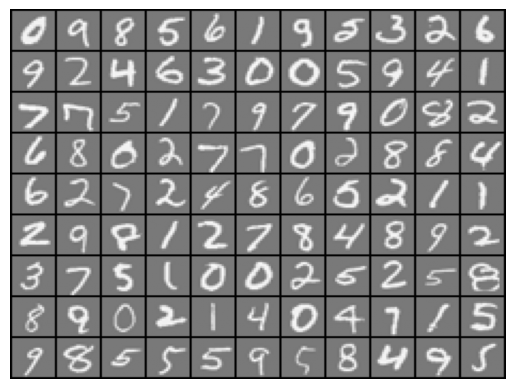

In [32]:
# Randomly select 100 data points to display.
selimgs = np.random.permutation(M.shape[0])
selimgs = selimgs[1:100]
disp.displaydata(M[selimgs,:])

### Part 2: Training One-vs-All Logistic Regression Regularized

In [33]:
classifiers = LogisticRegRegularizedMulticlass()

# Make a call to vectorized implementation.
classifiers.one_vs_all_vectorized(M, y.reshape((len(y), 1)),
                                  mappings.labels)

Executing vectorized version of algorithm...
0.00920590095453518 min cost estimation for label 0
0.013216317089402676 min cost estimation for label 1
0.05099223367761123 min cost estimation for label 2
0.05794723077300804 min cost estimation for label 3
0.033144430191229875 min cost estimation for label 4
0.054684047534060004 min cost estimation for label 5
0.018451881431334926 min cost estimation for label 6
0.030713136753165754 min cost estimation for label 7
0.07942081347765997 min cost estimation for label 8
0.07173163938991023 min cost estimation for label 9


In [34]:
# Following is non vectorized call, to test uncomment and

# comment vectorized call above. Non vectorized call is slower.
# classifiers.one_vs_all_non_vectorized(M, y.reshape((len(y), 1)),
#                                   mappings.labels)

### Part 3: Predicting for One-Vs-All

In [35]:
pred = classifiers.predict_one_vs_all(M)

print('Original label for each example')
print(y)

print('Predicted label for each example')
print(pred)
print('Predicted accuracy {}%.\n'.format(np.mean(pred == y) * 100))

Original label for each example
[0 0 0 ... 9 9 9]
Predicted label for each example
[0 0 0 ... 9 9 7]
Predicted accuracy 96.34%.



## Neural Networks

### Part 1: Loading and visualizing data, already done in exercise part 1 above

### Part 2: Loading Parameters

In [36]:
# Read pre trained theta1 parameters matrix is 25x401 
# but we transpose hence shape=401x25.
theta1 = np.transpose(np.loadtxt('data/ex3weights_theta1.dat', delimiter=','))

# Read pre trained theta1 parameters matrix is 26x10 
# but we transpose hence shape=26x10.
theta2 = np.transpose(np.loadtxt('data/ex3weights_theta2.dat', delimiter=','))

In [37]:
print('Parameters after transpose.')
print('theta1 {}'.format(theta1.shape))
print('theta2 {}'.format(theta2.shape))

Parameters after transpose.
theta1 (401, 25)
theta2 (26, 10)


### Part 3: Predicting using Forward Propagation

In [38]:
nn_fp = ForwardPropagation()
pred = nn_fp.predict(M, theta1, theta2)

# Map labels from Matlab 1-based indexing to 
# Python 0-based indexing.
pred = mappings.labels_matlab2python(pred)

print('Original label for each example')
print(y)

print('Predicted label for each example')
print(pred)
print('Predicted accuracy {}%.\n'.format(np.mean(pred == y) * 100))

Original label for each example
[0 0 0 ... 9 9 9]
Predicted label for each example
[0 0 0 ... 9 9 9]
Predicted accuracy 97.52%.

